## Data pre-processing
### Subtask



* **Loading**: Load train and test data "train.parquet" and "test.parquet"

* **Visualize**: It's good to visualize the class distribution before we apply balanced class propertions

* **Stratification**: Performing a stratified train-validation split on the train_df DataFrame guarantees:

    * Balanced class proportions across splits.

    * More reliable validation metrics (especially for imbalanced datasets like medical imaging).

Mounted at /content/drive
Drive mounted.


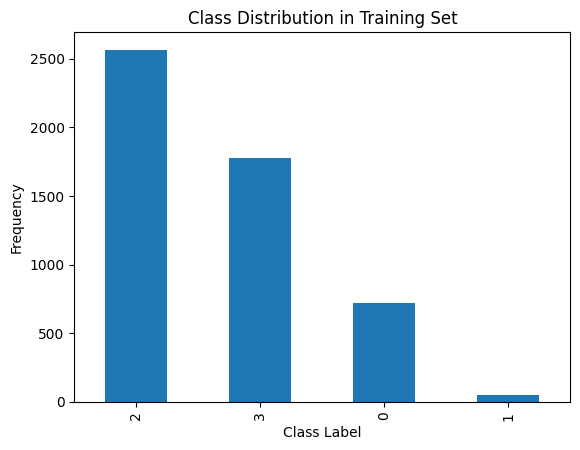

In [ ]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive

drive_mounted = False
if not drive_mounted:
    drive.mount('/content/drive', force_remount=True)
    drive_mounted = True
    print("Drive mounted.")
drive_path = "/content/drive/MyDrive/Projects/HealthCare/AI_Alzheimer_Detection/data"

train_filepath = os.path.join(drive_path, "train.parquet")
test_filepath = os.path.join(drive_path, "test.parquet")
train_df = pd.read_parquet(train_filepath)
test_df  = pd.read_parquet(test_filepath)

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)

def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):

        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]

        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))

#Below graph shows the class distribution in the training set has more number of samples from class/label 2
train_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Frequency')

#Stratification
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])


## Transformation
### Subtask

**Transfrmation**: Setup trasformation settings for both train and test dataset

In [ ]:
# ------------------------------------------------------------
# Image Transformation Pipelines for MRI Classification
# ------------------------------------------------------------

from torchvision import transforms

train_transform = transforms.Compose([
    # Randomly crops a region of the image and resizes it to 224x224.
    # The crop size varies between 80% and 100% of the original image area.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    # Randomly flips the image horizontally with a 50% chance.
    # Useful for symmetry-based augmentation in medical images.
    transforms.RandomHorizontalFlip(),

    # Randomly rotates the image within ±15 degrees.
    # Helps the model become invariant to slight orientation changes.
    transforms.RandomRotation(15),

    # Randomly adjusts brightness and contrast by ±10%.
    # Simulates lighting variations and scanner differences.
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    # Converts the PIL image to a PyTorch tensor and scales pixel values to [0, 1].
    transforms.ToTensor(),

    # Normalizes the image using mean and std of 0.5 (for grayscale images).
    # This centers pixel values around 0 with a range of [-1, 1].
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# -----------------------------------------------
# Testing/Validation Transformations (No Augmentation)
# -----------------------------------------------
# These are deterministic and ensure consistent evaluation.
test_transform = transforms.Compose([
    # Resizes the image to a fixed size of 224x224.
    transforms.Resize((224, 224)),

    # Converts the image to a tensor.
    transforms.ToTensor(),

    # Applies the same normalization as the training set.
    transforms.Normalize(mean=[0.5], std=[0.5])
])


## Data preparation & Clasification
### Subtask

* **Create Dataset**:Create PyTorch-compatible datasets from DataFrames

* **MRI Clasification**: Weighted Sampling to Handle Class Imbalance

* **Dataloader**: DataLoader Setup for Model Training

In [ ]:
# ------------------------------------------------------------
# Custom PyTorch Dataset for MRI Images from DataFrame
# ------------------------------------------------------------

from torch.utils.data import Dataset
from PIL import Image

class MRIDatasetFromDF(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_array = self.df.iloc[idx]['image']
        label = int(self.df.iloc[idx]['label'])

        # Convert NumPy array to grayscale PIL image
        image = Image.fromarray(image_array.astype(np.uint8)).convert('L')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

# -----------------------------------------------
# Dataset Preparation for MRI Classification
# -----------------------------------------------
train_dataset = MRIDatasetFromDF(train_df, transform=train_transform)
val_dataset   = MRIDatasetFromDF(val_df, transform=test_transform)
test_dataset  = MRIDatasetFromDF(test_df, transform=test_transform)


from torch.utils.data import WeightedRandomSampler

# Count samples per class in training data
class_counts = train_df['label'].value_counts().sort_index().values

# Compute inverse frequency weights for each class
class_weights = 1. / class_counts

# Assign a weight to each sample based on its class
sample_weights = [class_weights[label] for label in train_df['label']]

# Create a sampler that draws samples with replacement,
# favoring underrepresented classes to balance training batches
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

from torch.utils.data import DataLoader

# Use weighted sampler for training to mitigate class imbalance
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# Use standard loaders for validation and testing (no sampling)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)


##Model Processing
##Subtask


**Model settings**:
Loss Function, Optimizer, and Learning Rate Scheduler

**Training setup**: Load EfficientNet-B0 model for transfer learning and setting
Class Weights for Imbalanced Data

In [ ]:
# ------------------------------------------------------------
# Model Setup for Multi-Label MRI Classification with EfficientNet
# ------------------------------------------------------------

import torch
import torch.optim as optim
import torch.nn as nn

# Select GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)


# Modify the first convolutional layer to accept 1-channel (grayscale) MRI images
model.features[0][0] = nn.Conv2d(
    in_channels=1, out_channels=32,
    kernel_size=3, stride=2, padding=1, bias=False
)
num_classes = len(train_df['label'].unique())

# Replace the final classification layer to match the number of output classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute inverse frequency weights for each class to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label'].values
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use BCEWithLogitsLoss for multi-label classification (assumes sigmoid activation on outputs)
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer with default beta values and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler that reduces LR by factor of 0.5 if validation loss plateaus for 3 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 93.5MB/s]


##Training & Validation
###Subtask
* Set training parameters

* Training Phase loop (with Mixup)

* Validate traning with Early Stopping Logic

In [ ]:
# ------------------------------------------------------------
# Training Loop with Mixup Augmentation and Early Stopping
# ------------------------------------------------------------

import torch.nn.functional as F
num_epochs = 30
best_val_acc = 0
patience_counter = 0
patience_limit = 5  # Stop training if no improvement for 5 consecutive epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get output shape for one-hot encoding
        outputs = model(images)

        # Apply Mixup augmentation
        lam = np.random.beta(0.4, 0.4)  # Sample mixing coefficient from Beta distribution
        index = torch.randperm(images.size(0))  # Shuffle indices for mixing

        # Mix images and one-hot encoded labels
        mixed_images = lam * images + (1 - lam) * images[index]
        num_classes = outputs.size(1)
        labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
        labels_mixed = lam * labels_onehot + (1 - lam) * labels_onehot[index]

        # Forward pass on mixed images
        outputs = model(mixed_images)

        # Compute loss using mixed labels
        loss = criterion(outputs, labels_mixed)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # -------------------------------
    # Validation Phase
    # -------------------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Convert labels to one-hot encoding for BCEWithLogitsLoss
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()
            loss = criterion(outputs, labels_onehot)
            val_loss += loss.item()

            # Compute accuracy using argmax over softmax probabilities
            probs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    # Adjust learning rate if validation loss plateaus
    scheduler.step(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # -------------------------------
    # Early Stopping Logic
    # -------------------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset counter on improvement
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break


Epoch [1/30] | Train Loss: 0.4590 | Val Loss: 0.3694 | Val Acc: 59.86%
Epoch [2/30] | Train Loss: 0.3991 | Val Loss: 0.3708 | Val Acc: 62.11%
Epoch [3/30] | Train Loss: 0.3776 | Val Loss: 0.3953 | Val Acc: 60.84%
Epoch [4/30] | Train Loss: 0.3603 | Val Loss: 0.3203 | Val Acc: 68.65%
Epoch [5/30] | Train Loss: 0.3425 | Val Loss: 0.3754 | Val Acc: 62.70%
Epoch [6/30] | Train Loss: 0.3425 | Val Loss: 0.2797 | Val Acc: 76.76%
Epoch [7/30] | Train Loss: 0.3190 | Val Loss: 0.2312 | Val Acc: 80.08%
Epoch [8/30] | Train Loss: 0.3129 | Val Loss: 0.2544 | Val Acc: 78.03%
Epoch [9/30] | Train Loss: 0.3046 | Val Loss: 0.2643 | Val Acc: 79.59%
Epoch [10/30] | Train Loss: 0.2823 | Val Loss: 0.2105 | Val Acc: 84.57%
Epoch [11/30] | Train Loss: 0.2782 | Val Loss: 0.1997 | Val Acc: 85.16%
Epoch [12/30] | Train Loss: 0.2598 | Val Loss: 0.2044 | Val Acc: 84.18%
Epoch [13/30] | Train Loss: 0.2636 | Val Loss: 0.1402 | Val Acc: 90.82%
Epoch [14/30] | Train Loss: 0.2635 | Val Loss: 0.1403 | Val Acc: 89.65%
E

##Save model
Save the model's learned parameters (weights and biases) to a file.
This stores only the state_dict (not the full model architecture), which can be reloaded later for inference or fine-tuning.

In [ ]:

model_filepath = os.path.join(drive_path, "AI_Alzmrmdl_enetb0.pth")
torch.save(model.state_dict(), model_filepath)


##Load Model file

In [ ]:
from torchvision import models
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(weights=None)
activations = []
gradients = []

model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
model = model.to(device)
model.load_state_dict(torch.load(model_filepath, map_location=device))


<All keys matched successfully>

##Evaluation
###
  Plot SHAP overlay

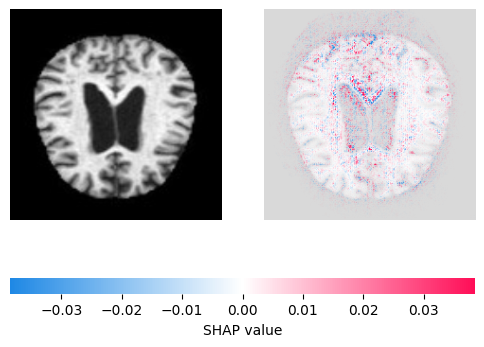

In [ ]:
#-----------------------------------------------------------------------------------
# Model Evaluation: SHAP (SHapley Additive exPlanations) for Model Interpretability
#-----------------------------------------------------------------------------------

import shap
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn

# Patch SiLU globally to avoid in-place ops on views
class SafeSiLU(nn.SiLU):
    def forward(self, input):
        return F.silu(input.clone(), inplace=self.inplace)

def patch_silu(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.SiLU):
            parent = model
            parts = name.split('.')
            for part in parts[:-1]:
                parent = getattr(parent, part)
            setattr(parent, parts[-1], SafeSiLU(inplace=module.inplace))

# Load EfficientNet-B0 and modify for grayscale input and 4-class output
model = models.efficientnet_b0(weights=None)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

# Load trained weights
model.load_state_dict(torch.load(model_filepath, map_location="cpu"))

# Patch SiLU and set eval mode
patch_silu(model)
model.eval().to(device)

# Wrap model to avoid view-related gradient errors
class SafeModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x.clone())

safe_model = SafeModel(model)

# Prepare background data for SHAP
background = next(iter(train_loader))[0][:100].to(device)

# Initialize SHAP explainer with safe model
explainer = shap.GradientExplainer(safe_model, background)

# Select test samples
test_images, _ = next(iter(test_loader))
# Select a single test image
test_image = test_images[0].unsqueeze(0)  # shape: (1, 1, 224, 224)

# Compute SHAP values for the single image
shap_values = explainer.shap_values(test_image)

# Select SHAP values for class 0
shap_values_class0 = shap_values[0][0]  # shape: (224, 224)

# Convert grayscale image to RGB format
image = test_image[0].cpu().numpy().squeeze(0)  # shape: (224, 224)
image_rgb = np.stack([image]*3, axis=-1)        # shape: (224, 224, 3)

# Normalize to [0, 1] range for imshow
image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min())

# Reshape to batch format for SHAP
image_rgb_batch = np.expand_dims(image_rgb, axis=0)  # shape: (1, 224, 224, 3)
shap_values_batch = [np.expand_dims(shap_values_class0, axis=0)]  # shape: (1, 224, 224)

# Plot SHAP overlay
shap.image_plot(shap_values_batch, image_rgb_batch)


##Evaluation
###Subtask
  * Display or analyze the confidence scores

  * Plot entropy per sample

Sample 1 | True Label: 3 | Confidences: [1.4799613e-03 1.1976934e-03 9.9638271e-01 9.3960756e-04]
Sample 2 | True Label: 0 | Confidences: [9.9812013e-01 6.1332854e-04 9.7786763e-04 2.8866084e-04]
Sample 3 | True Label: 2 | Confidences: [5.7669781e-04 8.8484224e-04 9.9810553e-01 4.3284416e-04]
Sample 4 | True Label: 3 | Confidences: [4.8993592e-04 7.6877547e-04 5.1646552e-04 9.9822479e-01]
Sample 5 | True Label: 0 | Confidences: [9.9817538e-01 8.5442647e-04 5.1768287e-04 4.5234774e-04]
Sample 6 | True Label: 3 | Confidences: [1.9869782e-04 2.1894417e-04 4.1861971e-05 9.9954057e-01]
Sample 7 | True Label: 2 | Confidences: [6.9232938e-06 3.9428276e-05 9.9994671e-01 6.8688855e-06]
Sample 8 | True Label: 2 | Confidences: [4.6224690e-05 2.0426005e-04 9.9973303e-01 1.6449525e-05]
Sample 9 | True Label: 2 | Confidences: [0.01559338 0.00589997 0.5298096  0.448697  ]
Sample 10 | True Label: 3 | Confidences: [3.2340424e-04 4.9532496e-04 2.0956213e-04 9.9897170e-01]


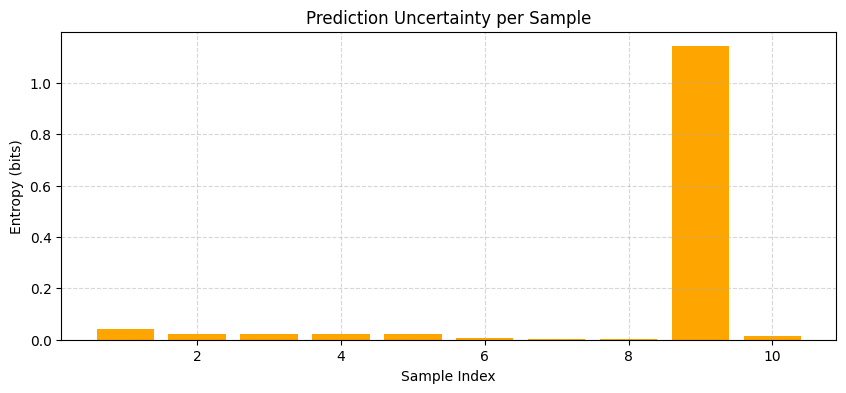

In [ ]:
# ------------------------------------------------------------
# Model Evaluation: Displaying Confidence Scores for One Batch
# ------------------------------------------------------------

# Set the model to evaluation mode.
# This disables dropout and batch normalization updates for consistent inference.
model.eval()

# Disable gradient computation to reduce memory usage and speed up inference.
import torch.nn.functional as F
sample_confidences = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        true_labels.extend(labels.cpu().numpy())
        outputs = model(images)

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)

        # Move to CPU and convert to NumPy
        batch_confidences = probs.cpu().numpy()

        # Append to list
        sample_confidences.extend(batch_confidences)

        # Stop after collecting 20 samples
        if len(sample_confidences) >= 10:
            sample_confidences = sample_confidences[:10]
            break

for i, conf in enumerate(sample_confidences):
    true_label = true_labels[i]
    print(f"Sample {i+1} | True Label: {true_label} | Confidences: {conf}")


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Assuming sample_confidences is a list of softmax outputs (shape: [num_samples, num_classes])
entropies = [entropy(probs, base=2) for probs in sample_confidences]

plt.figure(figsize=(10, 4))
plt.bar(range(1, len(entropies) + 1), entropies, color='orange')
plt.xlabel("Sample Index")
plt.ylabel("Entropy (bits)")
plt.title("Prediction Uncertainty per Sample")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##Evaluation
###Plot the confusion matrix as a heatmap

Test Accuracy: 96.95%
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       172
           1       1.00      1.00      1.00        15
           2       0.97      0.97      0.97       634
           3       0.97      0.96      0.96       459

    accuracy                           0.97      1280
   macro avg       0.97      0.98      0.98      1280
weighted avg       0.97      0.97      0.97      1280



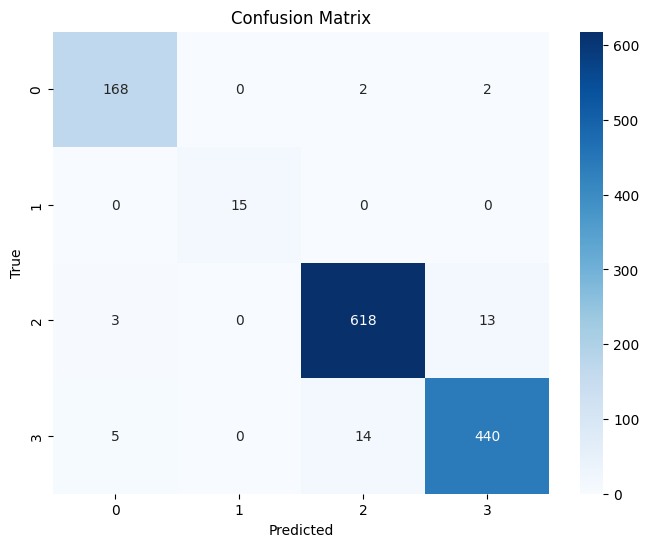

In [ ]:
# ------------------------------------------------------------
# Model Evaluation: Confusion Matrix Visualization
# ------------------------------------------------------------

from sklearn.metrics import classification_report, confusion_matrix  # For evaluation metrics
import seaborn as sns  # For heatmap visualization
import matplotlib.pyplot as plt  # For plotting

# Set the model to evaluation mode to disable dropout and batch norm updates
model.eval()

# Initialize lists to store all predicted and true labels
all_preds = []
all_labels = []

# Disable gradient calculation for faster inference and lower memory usage
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the appropriate device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the model to get raw output scores (logits)
        outputs = model(images)

        # Get the predicted class by selecting the index with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and true labels for later evaluation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print overall test accuracy
accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {accuracy:.2f}%")

# Print detailed classification metrics: precision, recall, f1-score, and support per class
print(classification_report(all_labels, all_preds))

# Compute the confusion matrix to visualize prediction errors
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Annotate with counts, use blue color map
plt.title("Confusion Matrix")  # Title of the plot
plt.xlabel("Predicted")  # Label for x-axis
plt.ylabel("True")  # Label for y-axis
plt.show()  # Display the plot


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=912b8cd9b2f5911b472c71618b298f19c59657ed46212bfd0e646bc23242eb51
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


##Evaluation
###Grad-CAM Visualization

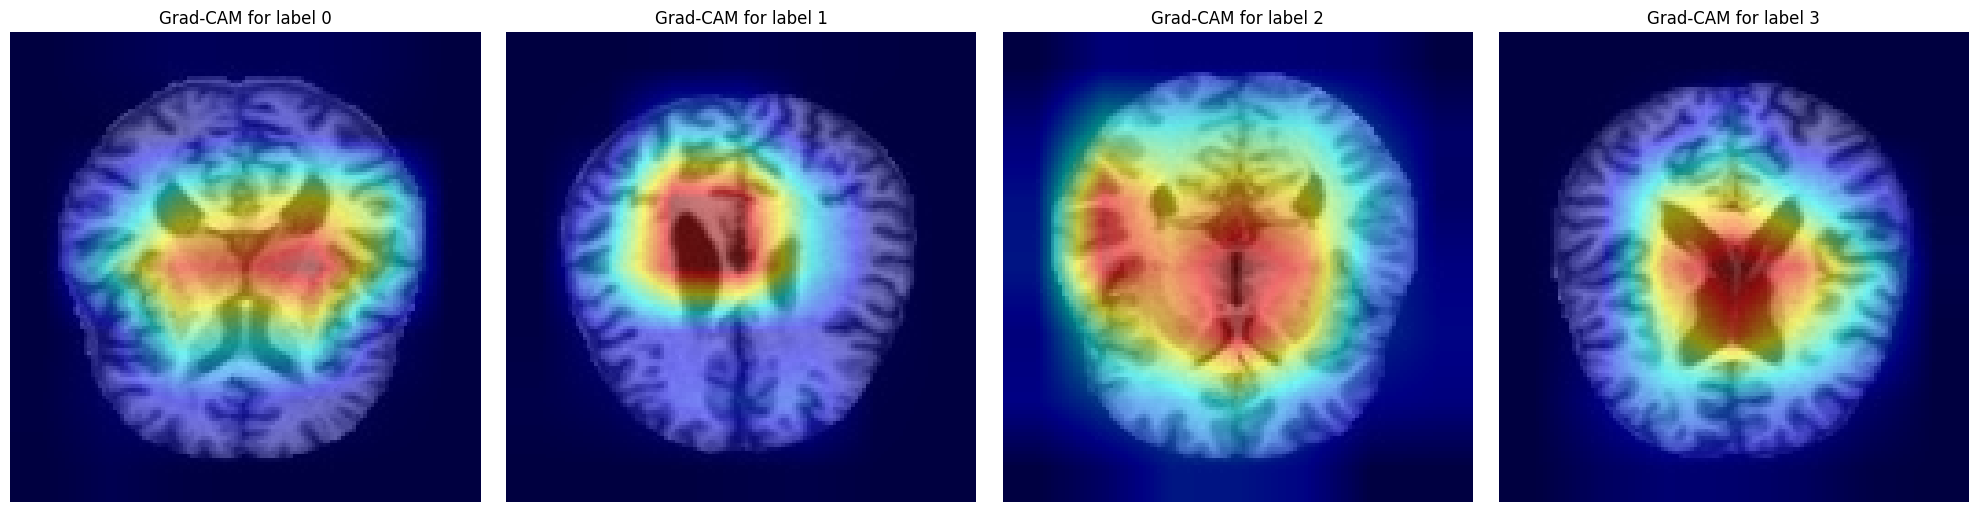

In [ ]:
#----------------------------------------------------------------------------
# Model Evaluation: Grad-CAM Visualization for Model Interpretability
#----------------------------------------------------------------------------

# Select one sample image for each class label (0 to 3) from the validation dataframe
samples_by_label = [val_df[val_df['label'] == i].iloc[0] for i in range(4)]

# Import Grad-CAM utilities for visualization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Import plotting and image processing libraries
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

# Define the target layer for Grad-CAM (last convolutional layer of DenseNet121)
target_layer = model.features[-1]

# Create a 1-row, 4-column subplot layout for displaying Grad-CAM visualizations
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Loop through each selected sample (one per class)
for i, sample in enumerate(samples_by_label):
    # Extract image data and label from the sample
    image_array = sample['image']
    label = int(sample['label'])

    # Convert image array to grayscale PIL image, then apply test transform and move to device
    image = Image.fromarray(image_array.astype(np.uint8)).convert('L')
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    # Initialize Grad-CAM with the model and target layer
    cam = GradCAM(model=model, target_layers=[target_layer])
    cam.__enter__()  # Ensure hooks are properly registered

    # Specify the target class for which CAM should be generated
    targets = [ClassifierOutputTarget(label)]

    # Generate the grayscale CAM for the input tensor
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    cam.__exit__(None, None, None)  # Clean up hooks

    # Prepare the RGB version of the original image for overlay
    rgb_image = np.stack([image_array / 255.0] * 3, axis=-1)

    # Resize the CAM to match the original image dimensions
    grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))

    # Overlay the CAM on the original image
    visualization = show_cam_on_image(rgb_image, grayscale_cam_resized, use_rgb=True)

    # Display the visualization in the subplot
    axs[i].imshow(visualization)
    axs[i].set_title(f"Grad-CAM for label {label}")
    axs[i].axis('off')  # Hide axis ticks for cleaner display

plt.tight_layout()
plt.show()


##Summary
###Evalution result analysis
* SHAP image showcases how the model predicted an MRI brain scan for Alzheimer’s stage classification. It’s a powerful interpretability tool that reveals which regions of the brain influenced the model’s prediction—a critical step for clinical transparency
* Prediction uncertainty chart visualizes for 10 MRI samples used
in Alzheimer’s stage classification. It shows the accuracy higher than 90% which revels strong accuracy.
* Model’s confidence scores visualization chart for 10 MRI samples across four Alzheimer’s stages (Class 0 to Class 3).The matrix reveals strong accuracy for each true label vs confidence highest scrore.
* With Test Accuracy: 93.67% confusion matrix visualizes the classification performance of your Alzheimer’s detection model across four stages (Classes 0–3.)The matrix reveals strong overall accuracy, especially for Classes 2 and 3, with some overlap between adjacent stages—common in progressive neurological conditions.
* Grad-CAM Visualization for Model Interpretability for Alzheimer’s
stage classification using MRI scans. Grad-CAM (Gradient-weighted Class Activation
Mapping) highlights the regions of the brain that the neural network focuses on when
predicting each class:
  * Label 0 to Label 3 correspond to different stages of Alzheimer’s progression.
  * Red regions indicate areas with the strongest influence on the model’s
decision.
  * Blue regions show minimal contribution.

Each visualization reveals distinct activation patterns, suggesting that the model
learns stage-specific anatomical features.

##Appendix
###Function to test Single Image
  * Final function to predict Alzheimer's disease stage from a single MRI image.
  * Includes Grad-CAM visualization to highlight regions influencing the model's decision.
  * This implementation can be extended for batch processing or integration into a web service.

Predicted Alzheimer stage label: 3 


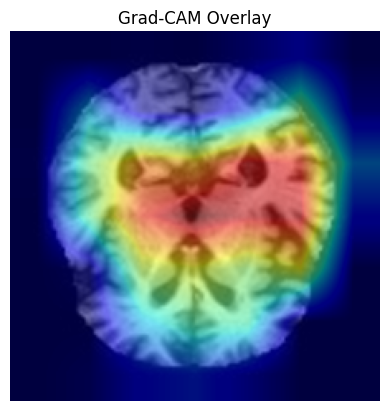

In [ ]:

from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(weights=None)
activations = []
gradients = []

model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=32,
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
model = model.to(device)
model.load_state_dict(torch.load(model_filepath, map_location=device))

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def show_gradcam(image_path, cam):
    image = Image.open(image_path).convert('L').resize((224, 224))
    image_np = np.array(image)

    plt.imshow(image_np, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

def predict_with_gradcam(image_path):

    image = Image.open(image_path).convert('L')
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    model.eval()
    activations.clear()
    gradients.clear()

    output = model(input_tensor)
    pred_class = output.argmax(dim=1)

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Get gradients and activations
    grad = gradients[0].cpu().detach()
    act = activations[0].cpu().detach()

    # Compute Grad-CAM
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = (weights * act).sum(dim=1).squeeze()
    cam = torch.relu(cam)

    # Normalize and resize
    cam -= cam.min()
    cam /= cam.max()
    cam = transforms.Resize((224, 224))(cam.unsqueeze(0)).squeeze()

    return pred_class.item(), cam.numpy()

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer = model.features[-1][0]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)
sample_iput_image = os.path.join(drive_path, "MRI_image1.png")

#al_stage = predict_single_image(image_path)
#print(f"Predicted Alzheimer stage lebel: {al_stage} ")

label, cam = predict_with_gradcam(sample_iput_image)
print(f"Predicted Alzheimer stage label: {label} ")
show_gradcam(sample_iput_image, cam)
